In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
daily_result_df = pd.read_csv("../data/daily_result_data_senova.csv")
totla_result_df = pd.read_csv("../data/total_result_data_by_fy_senova.csv")
network_result_df = pd.read_csv("../data/静岡セノバネットワークまとめ用.csv")
chart_result_df = pd.read_csv("../data/静岡セノバレーダーチャート用.csv")

In [ ]:
import pandas as pd
import numpy as np
import os
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

def calc_asociation(df, min_support=0.0001, max_len=2):
    # 1) 購買重複データの削除
    #    カード番号 → ユーザーID
    #    利用日時 → トランザクション日時
    #    利用金額 → トランザクション金額
    df_sorted = df.sort_values(
        by=['カード番号', '利用日時', '利用金額'],
        ascending=[True, True, False]
    )
    df_unique = df_sorted.drop_duplicates(
        subset=['カード番号', '利用日時'],
        keep='first'
    )

    # 2) Pivotテーブル作成
    #    グループ化キーは（カード番号, ショップ名略称）
    temp = df_unique.groupby(['カード番号', 'ショップ名略称']).count()
    pivot = (
        pd.DataFrame(temp['利用日時'])
        .rename(columns={'利用日時': '購入数'})
        .unstack()
        .fillna(0)
    )
    # 購入の有無を True/False に
    basket = pivot.applymap(lambda x: x > 0)
    # 最初の行だけ除外（元コードに合わせて）
    basket = basket[1:]
    # MultiIndex を解除
    basket.columns = basket.columns.droplevel(0)
    # もし '-' 列があれば削除
    if basket.columns[0] == '-':
        basket = basket.drop(basket.columns[0], axis=1)

    # 3) アソシエーション分析
    freq_item = apriori(
        basket,
        min_support=min_support,
        use_colnames=True,
        max_len=max_len,
        low_memory=True
    )
    rules = association_rules(
        freq_item,
        metric='lift',
        min_threshold=1,
        # 全アイテムセット数分だけ候補を出力
        num_itemsets=freq_item.shape[0]
    ).reset_index(drop=True)

    # 4) antecedents/consequents を文字列に変換
    for i in range(len(rules)):
        rules.at[i, 'antecedents'] = list(rules.at[i, 'antecedents'])[0]
        rules.at[i, 'consequents'] = list(rules.at[i, 'consequents'])[0]

    return rules

def build_node_edge_df(rules, mall_name, full_tenant_list=None):
    # edge_df: lift → Weight
    edge_df = (
        rules[['antecedents', 'consequents', 'lift']]
        .rename(columns={
            'antecedents': 'Source',
            'consequents':  'Target',
            'lift':         'Weight'
        })
    )
    # ルールに出てくるノード
    node_ids = pd.unique(edge_df[['Source','Target']].values.ravel('K'))

    if full_tenant_list is not None:
        all_ids = np.unique(np.concatenate([node_ids, full_tenant_list], axis=0))
    else:
        all_ids = node_ids

    node_df = pd.DataFrame({
        'Id':       node_ids,
        'is_added': False
    })
    added = np.setdiff1d(all_ids, node_ids)
    node_df = pd.concat([
        node_df,
        pd.DataFrame({'Id': added, 'is_added': True})
    ], ignore_index=True)

    return node_df, edge_df

# =====================
# メイン処理の例
# =====================



In [ ]:
df = calc_asociation(network_result_df, min_support=0.02, max_len=2)

/tmp/ipykernel_98189/2652966988.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = pivot.applymap(lambda x: x > 0)


/tmp/ipykernel_98189/3504914249.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


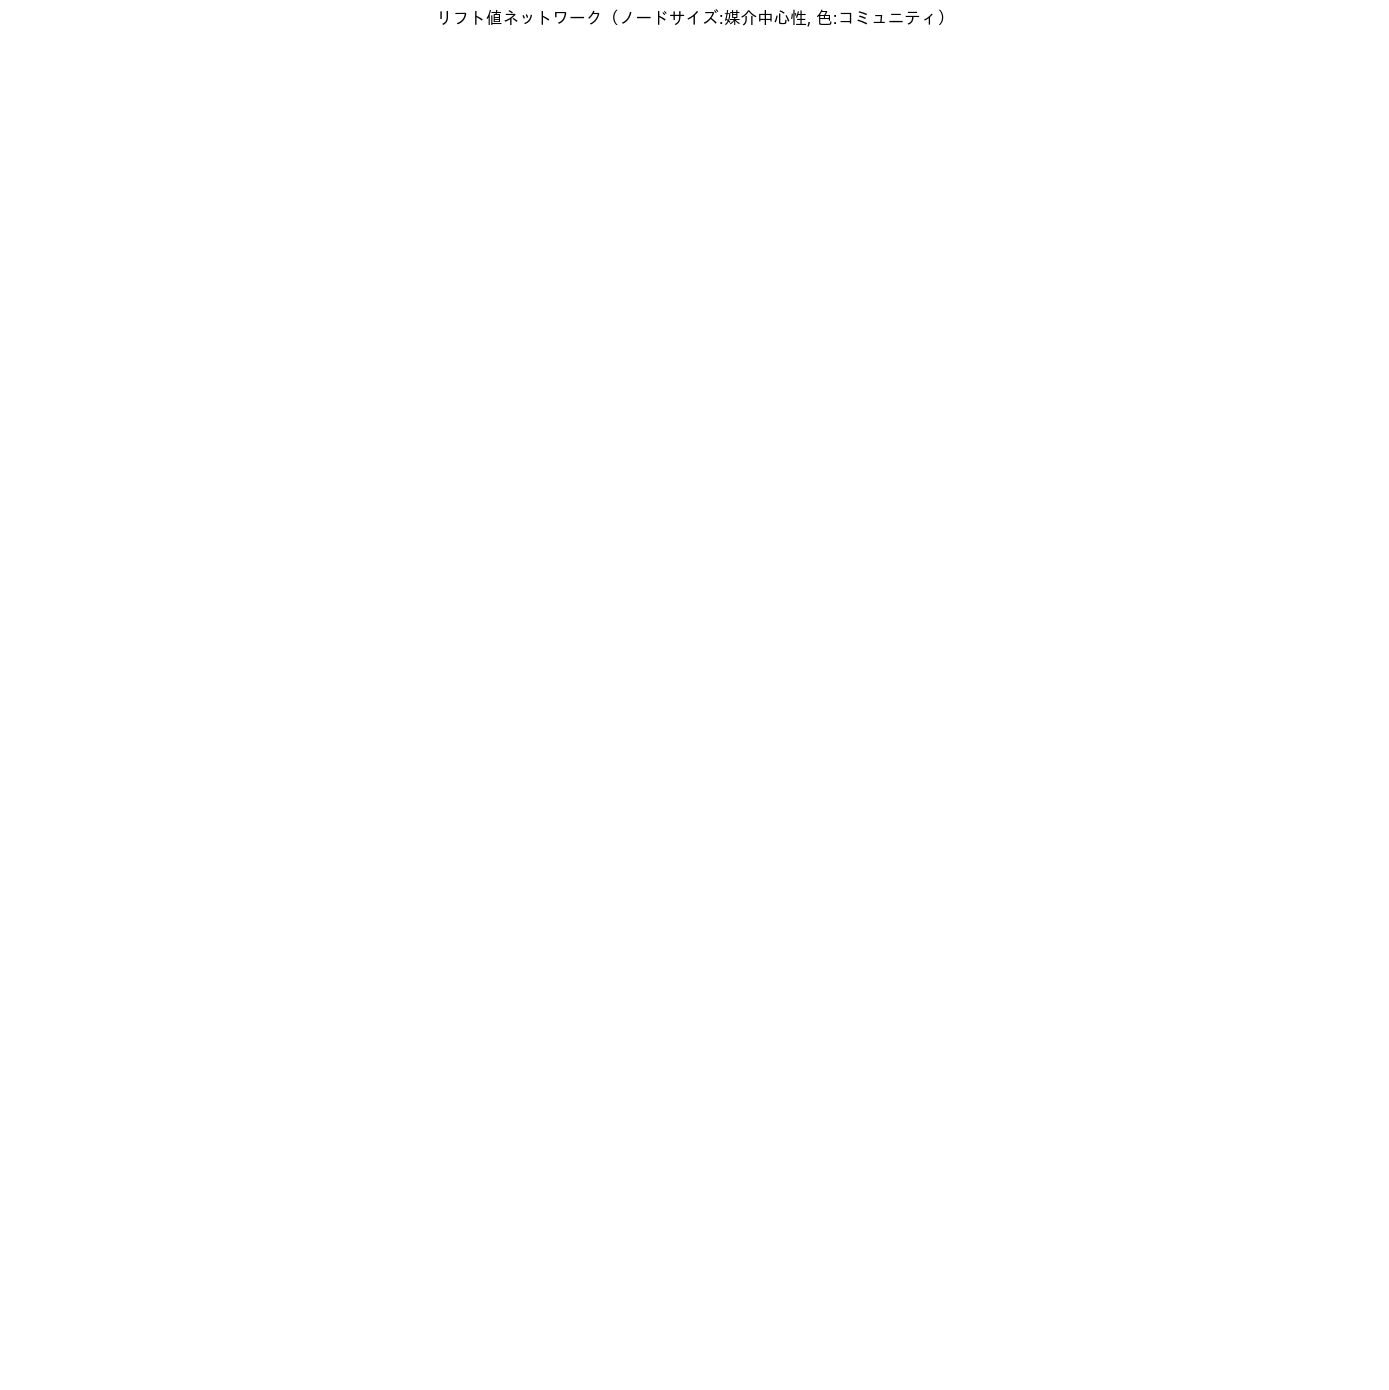

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from networkx.algorithms import community

# ——————————————
# DataFrame 読み込み済みを想定（df）
# df = pd.read_csv("your_rules.csv")
# ——————————————

# 日本語フォント設定（環境に合わせてパスを修正）
#jp_font_path = "/usr/share/fonts/truetype/ipaexfont-gothic/ipaexg.ttf"
#jp_font = fm.FontProperties(fname=jp_font_path)

# グラフ構築
G = nx.Graph()


# 媒介中心性を計算
bet_cent = nx.betweenness_centrality(G, weight='weight', normalized=True)
# ノードサイズ：0.001〜0.01 の間で調整（例）
node_sizes = [bet_cent[n] * 5000 + 100 for n in G.nodes()]

# コミュニティ検出（greedy_modularity_communities の例）
communities = community.greedy_modularity_communities(G, weight='weight')
# 各ノードにコミュニティ番号を割り当て
node_community = {}
for cid, com in enumerate(communities):
    for n in com:
        node_community[n] = cid

# カラーマップ準備
cmap = plt.cm.get_cmap('tab20')
node_colors = [cmap(node_community[n] % 20) for n in G.nodes()]

# レイアウト
pos = nx.spring_layout(G, seed=42)

# 描画
plt.figure(figsize=(14, 14))
# ノード
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)
# エッジ（lift に応じた太さ）
edge_widths = [d['weight'] * 1.5 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.5,
)
# ラベル（日本語フォント指定）
nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_family="IPAexGothic"
)

plt.title("リフト値ネットワーク（ノードサイズ:媒介中心性, 色:コミュニティ）")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

#network_result_df = pd.read_csv("../data/静岡セノバネットワークまとめ用.csv")
#chart_result_df = pd.read_csv("../data/静岡セノバレーダーチャート用.csv")
# ——————————————
# ① データ読み込み（既に df_transactions, df_rules が定義済みならこのブロックは不要）
df_transactions = pd.read_csv("../data/静岡セノバレーダーチャート用.csv", parse_dates=["利用日", "利用日時"])
df_rules       = pd.read_csv("../data/静岡セノバネットワークまとめ用.csv")
# ——————————————
df_rules = calc_asociation(df_rules, min_support=0.02, max_len=2)

# ② ネットワーク構築と媒介中心性計算
G = nx.Graph()
for _, row in df_rules.iterrows():
    src = row['antecedents']
    dst = row['consequents']
    lift_val = row['lift']
    G.add_edge(src, dst, weight=lift_val)
bet_cent = nx.betweenness_centrality(G, weight='weight', normalized=True)

# ③ テナント別トランザクション指標の計算
tenant_col = 'ショップ名略称'
group = df_transactions.groupby(tenant_col)

# ユニーク客数
unique_customers = group['会員番号'].nunique().rename('ユニーク客数')
# 売上
sales = group['利用金額'].sum().rename('売上')
# 訪問日数（利用日ベースのユニーク日数）
visit_days = group['利用日'].nunique().rename('訪問日数')
# 平均頻度（日数/ユニーク客数）
avg_freq = (visit_days / unique_customers).rename('平均頻度(日数/ユニーク客数)')
# 1日あたり購買金額
sales_per_day = (sales / visit_days).rename('1日あたり購買金額')

# 指標DataFrame統合
metrics_df = pd.concat([unique_customers, sales, avg_freq, sales_per_day], axis=1)

# ④ ネットワーク由来の媒介中心性を「日別合計媒介中心」として追加
bc_series = pd.Series(bet_cent, name='日別合計媒介中心')
metrics_df = metrics_df.join(bc_series, how='left')

# ⑤ インデックスをカラム化
metrics_df = metrics_df.reset_index().rename(columns={tenant_col: 'テナント名'})

# 表示
metrics_df


/tmp/ipykernel_98189/2652966988.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = pivot.applymap(lambda x: x > 0)


,テナント名,ユニーク客数,売上,平均頻度(日数/ユニーク客数),1日あたり購買金額,日別合計媒介中心
0,きものやまと,974,167466500,0.638604,2.692387e+05,NaN
1,さわやか,15421,98146620,0.046625,1.365043e+05,0.000000
2,じぶんまくら,687,51717543,0.425036,1.771149e+05,NaN
3,つるさく,23196,54359258,0.031212,7.508185e+04,0.000000
4,とんかつ新宿さぼてん,25924,108195354,0.027928,1.494411e+05,0.000000
...,...,...,...,...,...,...
115,静鉄ストア,125543,4370695933,0.005815,5.987255e+06,0.562136
116,靴下屋,15586,57609197,0.023868,1.548634e+05,0.000000
117,ＤＨＣ直営店,3864,89778895,0.187371,1.240040e+05,NaN
118,ＯＵＴＳＩＤＥ ＴＨ,8261,159309886,0.087641,2.200413e+05,0.000000


In [ ]:
metrics_df = metrics_df.sort_values(by='売上', ascending=False)
selected_tenant = list(metrics_df.columns[:5])
selected_tenant

['テナント名', 'ユニーク客数', '売上', '平均頻度(日数/ユニーク客数)', '1日あたり購買金額']

In [ ]:
selected_tenant = list(metrics_df["テナント名"].head(5).values)
selected_tenant

['きものやまと', 'さわやか', 'じぶんまくら', 'つるさく', 'とんかつ新宿さぼてん']

In [ ]:
metrics_df

,テナント名,ユニーク客数,売上,平均頻度(日数/ユニーク客数),1日あたり購買金額,日別合計媒介中心
0,きものやまと,974,167466500,0.638604,2.692387e+05,NaN
1,さわやか,15421,98146620,0.046625,1.365043e+05,0.000000
2,じぶんまくら,687,51717543,0.425036,1.771149e+05,NaN
3,つるさく,23196,54359258,0.031212,7.508185e+04,0.000000
4,とんかつ新宿さぼてん,25924,108195354,0.027928,1.494411e+05,0.000000
...,...,...,...,...,...,...
115,静鉄ストア,125543,4370695933,0.005815,5.987255e+06,0.562136
116,靴下屋,15586,57609197,0.023868,1.548634e+05,0.000000
117,ＤＨＣ直営店,3864,89778895,0.187371,1.240040e+05,NaN
118,ＯＵＴＳＩＤＥ ＴＨ,8261,159309886,0.087641,2.200413e+05,0.000000


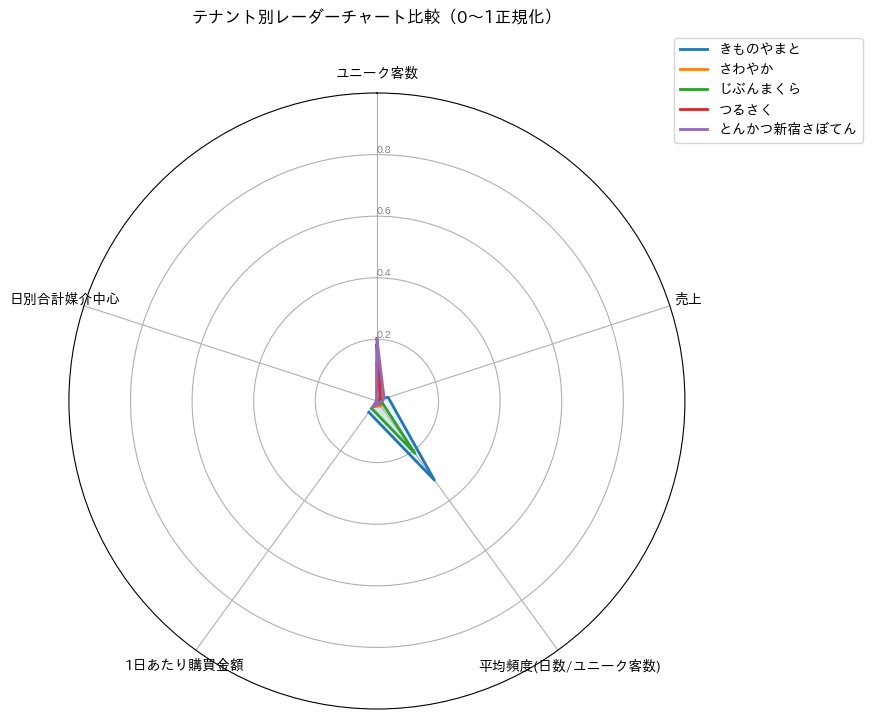

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- metrics_df が既に定義済みである前提で実行してください ---

# 1. プロット用メトリクス一覧
metrics = [
    "ユニーク客数",
    "売上",
    "平均頻度(日数/ユニーク客数)",
    "1日あたり購買金額",
    "日別合計媒介中心"
]

# 2. メトリクスを 0〜1 正規化
df_norm = metrics_df.copy()  # metrics_df は事前に定義してください
for m in metrics:
    min_v = df_norm[m].min()
    max_v = df_norm[m].max()
    df_norm[m] = (df_norm[m] - min_v) / (max_v - min_v) if max_v > min_v else 0.0

# 3. プロット対象テナントの例（必要に応じて書き換えてください）
selected_tenants = list(metrics_df["テナント名"].head(5).values)

# 4. レーダーチャート描画
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

angles = [n / float(len(metrics)) * 2 * math.pi for n in range(len(metrics))]
angles += angles[:1]

# 軸設定
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], metrics, fontsize=10)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
ax.set_ylim(0, 1)

# 各テナントのプロット
for tenant in selected_tenants:
    row = df_norm[df_norm["テナント名"] == tenant]
    if row.empty:
        continue
    values = row.iloc[0][metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=tenant)
    ax.fill(angles, values, alpha=0.1)

plt.title("テナント別レーダーチャート比較（0〜1正規化）", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


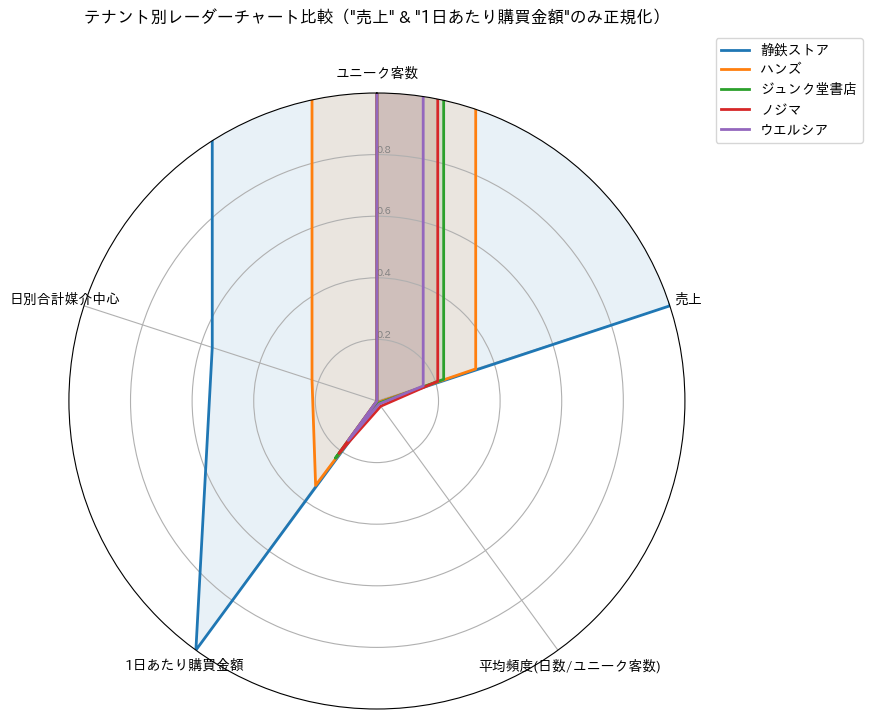

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 前提: metrics_df が既に定義済みであること ---

# 1. プロット用メトリクス一覧
metrics = [
    "ユニーク客数",
    "売上",
    "平均頻度(日数/ユニーク客数)",
    "1日あたり購買金額",
    "日別合計媒介中心"
]

# 2. 正規化対象メトリクスのみ 0〜1 正規化
norm_metrics = ["売上", "1日あたり購買金額"]

df_norm = metrics_df.copy()
for m in norm_metrics:
    min_v = df_norm[m].min()
    max_v = df_norm[m].max()
    if max_v > min_v:
        df_norm[m] = (df_norm[m] - min_v) / (max_v - min_v)
    else:
        df_norm[m] = 0.0

# 3. プロット対象テナント（例として上位5件を使用）
selected_tenants = list(metrics_df["テナント名"].head(5).values)

# 4. レーダーチャート描画
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

angles = [n / float(len(metrics)) * 2 * math.pi for n in range(len(metrics))]
angles += angles[:1]

# 軸設定
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], metrics, fontsize=10)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
ax.set_ylim(0, 1)

# 各テナントのプロット
for tenant in selected_tenants:
    row = df_norm[df_norm["テナント名"] == tenant]
    if row.empty:
        continue
    values = row.iloc[0][metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=tenant)
    ax.fill(angles, values, alpha=0.1)

plt.title("テナント別レーダーチャート比較（\"売上\" & \"1日あたり購買金額\"のみ正規化）", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


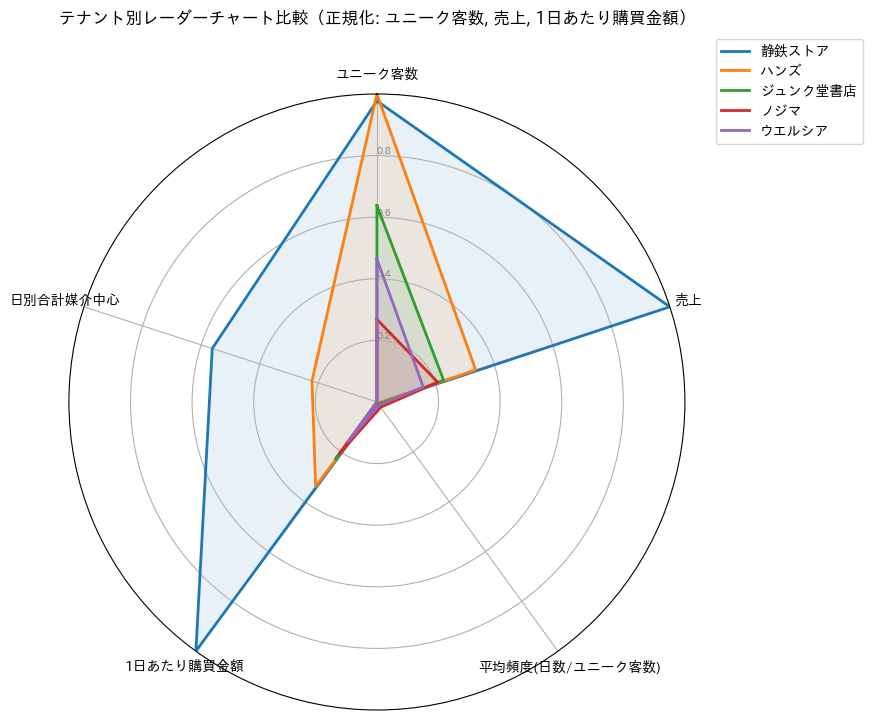

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 前提: metrics_df が既に定義済みであること ---

# 1. プロット用メトリクス一覧
metrics = [
    "ユニーク客数",
    "売上",
    "平均頻度(日数/ユニーク客数)",
    "1日あたり購買金額",
    "日別合計媒介中心"
]

# 2. 0～1 正規化対象メトリクス
norm_metrics = ["ユニーク客数", "売上", "1日あたり購買金額"]

df_norm = metrics_df.copy()
for m in norm_metrics:
    min_v = df_norm[m].min()
    max_v = df_norm[m].max()
    if max_v > min_v:
        df_norm[m] = (df_norm[m] - min_v) / (max_v - min_v)
    else:
        df_norm[m] = 0.0

# 3. プロット対象テナント（上位5件を例として使用）
selected_tenants = list(metrics_df["テナント名"].head(5).values)

# 4. レーダーチャート描画
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

angles = [n / float(len(metrics)) * 2 * math.pi for n in range(len(metrics))]
angles += angles[:1]

# 軸設定
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], metrics, fontsize=10)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
ax.set_ylim(0, 1)

# 各テナントのプロット
for tenant in selected_tenants:
    row = df_norm[df_norm["テナント名"] == tenant]
    if row.empty:
        continue
    values = row.iloc[0][metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=tenant)
    ax.fill(angles, values, alpha=0.1)

plt.title("テナント別レーダーチャート比較（正規化: ユニーク客数, 売上, 1日あたり購買金額）", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


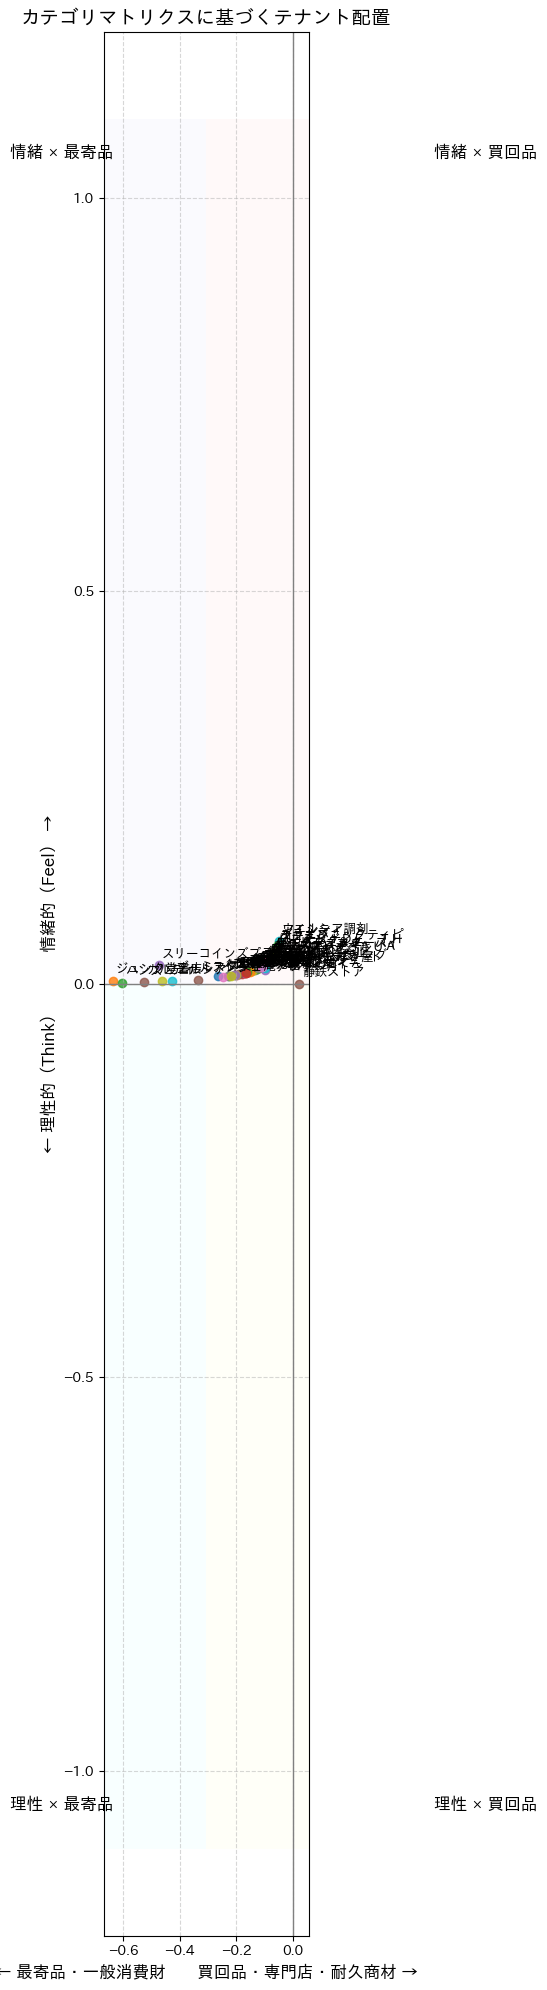

In [13]:
from sklearn.preprocessing import MinMaxScaler

# ---- Step 2: スケーリング ----
scaler = MinMaxScaler()
features = ["ユニーク客数", "売上", "平均頻度(日数/ユニーク客数)", "1日あたり購買金額", "日別合計媒介中心"]
#metrics_df_scaled = metrics_df.copy()
#metrics_df_scaled[features] = scaler.fit_transform(metrics_df[features])

# ---- Step 3: カテゴリマトリクス上の位置（X, Y）計算 ----
metrics_df["X"] = (
    -metrics_df["ユニーク客数"]
    - metrics_df["売上"]
    + metrics_df["1日あたり購買金額"]
    + metrics_df["日別合計媒介中心"]
)

metrics_df["Y"] = (
    -metrics_df["売上"]
    + metrics_df["平均頻度(日数/ユニーク客数)"]
    + metrics_df["1日あたり購買金額"]
)

# ---- Step 4: 日本語フォント設定（適宜変更）----
plt.rcParams['font.family'] = 'IPAexGothic'  # 他: 'Noto Sans CJK JP', 'MS Gothic', 'AppleGothic'など

# ---- Step 5: プロット ----
fig, ax = plt.subplots(figsize=(20, 20))
ax.axhline(0, color="gray", linewidth=1)
ax.axvline(0, color="gray", linewidth=1)
ax.set_title("カテゴリマトリクスに基づくテナント配置", fontsize=14)
ax.set_xlabel("← 最寄品・一般消費財       買回品・専門店・耐久商材 →", fontsize=12)
ax.set_ylabel("← 理性的（Think）            情緒的（Feel） →", fontsize=12)

# 背景色（4象限）
ax.axhspan(0, 1.1, xmin=0.5, xmax=1.0, facecolor='mistyrose', alpha=0.2)    # 情緒×買回品
ax.axhspan(0, 1.1, xmin=0.0, xmax=0.5, facecolor='lavender', alpha=0.2)     # 情緒×最寄品
ax.axhspan(-1.1, 0, xmin=0.5, xmax=1.0, facecolor='lightyellow', alpha=0.2) # 理性×買回品
ax.axhspan(-1.1, 0, xmin=0.0, xmax=0.5, facecolor='lightcyan', alpha=0.2)   # 理性×最寄品

# ラベル表示
ax.text(-1.0, 1.05, "情緒 × 最寄品", fontsize=12)
ax.text(0.5, 1.05, "情緒 × 買回品", fontsize=12)
ax.text(-1.0, -1.05, "理性 × 最寄品", fontsize=12)
ax.text(0.5, -1.05, "理性 × 買回品", fontsize=12)

# テナントのプロット
for _, row in metrics_df_scaled.iterrows():
    ax.scatter(row["X"], row["Y"], alpha=0.8)
    ax.text(row["X"] + 0.01, row["Y"] + 0.01, row["テナント名"], fontsize=9)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

ユニーク客数が多いという事は「最寄品・一般消費財」が高くなることを意味する。売上が多い事は「最寄品・一般消費財」「理性的」であることを意味する。平均頻度(日数/ユニーク客数)がおおきいことは、「最寄品・一般消費財」「情緒的」であることを意味する。1日あたり購買金額が大きい事は「回回り品・専門店・耐久商材」「情緒的」であることを意味する。日別合計媒介中心が大きい事は、「買回品・専門店・耐久商材」が高いことを意味する。


In [19]:
import ipywidgets as widgets
from IPython.display import display


In [ ]:
# --- 正規化 ---
norm_metrics = ["ユニーク客数", "売上", "1日あたり購買金額"]
df_norm = metrics_df.copy()
for m in norm_metrics:
    min_v = df_norm[m].min()
    max_v = df_norm[m].max()
    df_norm[m] = (df_norm[m] - min_v) / (max_v - min_v) if max_v > min_v else 0.0

# --- スコア計算 ---
df_norm["X"] = (
    -df_norm["ユニーク客数"]
    - df_norm["売上"]
    + df_norm["1日あたり購買金額"]
    + df_norm["日別合計媒介中心"]
)
df_norm["Y"] = (
    -df_norm["売上"]
    + df_norm["平均頻度(日数/ユニーク客数)"]
    + df_norm["1日あたり購買金額"]
)

# --- インタラクティブウィジェット ---
tenant_selector = widgets.SelectMultiple(
    options=df_norm["テナント名"].tolist(),
    value=[df_norm["テナント名"].tolist()[0]],
    description="テナント選択",
    layout=widgets.Layout(width="50%")
)

# --- 描画関数 ---
def plot_matrix(selected_tenants):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title("カテゴリマトリクスにおけるテナント位置")
    ax.set_xlabel("← 最寄品・一般消費財　買回品・専門店 →")
    ax.set_ylabel("← 理性的（Think）　情緒的（Feel） →")

    # 背景の象限
    ax.axhspan(0, 1.1, xmin=0.5, xmax=1.0, facecolor='mistyrose', alpha=0.2)
    ax.axhspan(0, 1.1, xmin=0.0, xmax=0.5, facecolor='lavender', alpha=0.2)
    ax.axhspan(-1.1, 0, xmin=0.5, xmax=1.0, facecolor='lightyellow', alpha=0.2)
    ax.axhspan(-1.1, 0, xmin=0.0, xmax=0.5, facecolor='lightcyan', alpha=0.2)

    # 描画
    for _, row in df_norm[df_norm["テナント名"].isin(selected_tenants)].iterrows():
        ax.scatter(row["X"], row["Y"], s=100)
        ax.text(row["X"] + 0.01, row["Y"] + 0.01, row["テナント名"], fontsize=10)

    plt.grid(True)
    plt.show()

# --- インタラクション表示 ---
widgets.interact(plot_matrix, selected_tenants=tenant_selector)

In [ ]:
# --- 正規化対象のみスケーリング ---
norm_metrics = ["ユニーク客数", "売上", "1日あたり購買金額"]
df_norm = metrics_df.copy()
for m in norm_metrics:
    min_v = df_norm[m].min()
    max_v = df_norm[m].max()
    df_norm[m] = (df_norm[m] - min_v) / (max_v - min_v) if max_v > min_v else 0.0

# --- X/Yスコアの計算 ---
df_norm["X"] = (
    -df_norm["ユニーク客数"]
    - df_norm["売上"]
    + df_norm["1日あたり購買金額"]
    + df_norm["日別合計媒介中心"]
)
df_norm["Y"] = (
    -df_norm["売上"]
    + df_norm["平均頻度(日数/ユニーク客数)"]
    + df_norm["1日あたり購買金額"]
)

# --- ターミナルからテナント名入力 ---
print("▼選択可能なテナント一覧：")
for name in df_norm["テナント名"]:
    print("-", name)

selected_input = input("\n表示したいテナント名をカンマ区切りで入力してください（例：さわやか,靴下屋）: ")
selected_tenants = [s.strip() for s in selected_input.split(",")]

# --- プロット ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.axhline(0, color="gray")
ax.axvline(0, color="gray")
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("カテゴリマトリクスにおけるテナント位置")
ax.set_xlabel("← 最寄品・一般消費財　買回品・専門店 →")
ax.set_ylabel("← 理性的（Think）　情緒的（Feel） →")

# 背景色（象限）
ax.axhspan(0, 1.1, xmin=0.5, xmax=1.0, facecolor='mistyrose', alpha=0.2)
ax.axhspan(0, 1.1, xmin=0.0, xmax=0.5, facecolor='lavender', alpha=0.2)
ax.axhspan(-1.1, 0, xmin=0.5, xmax=1.0, facecolor='lightyellow', alpha=0.2)
ax.axhspan(-1.1, 0, xmin=0.0, xmax=0.5, facecolor='lightcyan', alpha=0.2)

# ラベル
ax.text(-1.4, 1.0, "情緒 × 最寄品", fontsize=10)
ax.text(0.6, 1.0, "情緒 × 買回品", fontsize=10)
ax.text(-1.4, -1.0, "理性 × 最寄品", fontsize=10)
ax.text(0.6, -1.0, "理性 × 買回品", fontsize=10)

# プロット
for _, row in df_norm[df_norm["テナント名"].isin(selected_tenants)].iterrows():
    ax.scatter(row["X"], row["Y"], s=100)
    ax.text(row["X"] + 0.01, row["Y"] + 0.01, row["テナント名"], fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()
